### **Set up environmenmt**

In [5]:
! cp kaggle.json ~/.kaggle/

In [6]:
! chmod 600 ~/.kaggle/kaggle.json

In [7]:
import kaggle
from kaggle.api.kaggle_api_extended import KaggleApi

In [8]:
api = KaggleApi()
api.authenticate()

### **Load data**

In [9]:
api.competition_download_file('digit-recognizer',
                              'train.csv')

100%|██████████| 9.16M/9.16M [00:00<00:00, 72.6MB/s]

In [10]:
api.competition_download_file('digit-recognizer',
                              'test.csv')

100%|██████████| 6.09M/6.09M [00:00<00:00, 149MB/s]

In [11]:
api.competition_download_file('digit-recognizer',
                              'sample_submission.csv')

100%|██████████| 235k/235k [00:00<00:00, 58.9MB/s]

### **Data Preparation**

In [12]:
import zipfile
with zipfile.ZipFile('train.csv.zip','r') as zipref:
  zipref.extractall()

In [13]:
with zipfile.ZipFile('test.csv.zip','r') as zipref:
  zipref.extractall()

In [14]:
# import the necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import collections
import cv2 as cv
import tensorflow as tf

from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Conv2D, Input, LeakyReLU, Dense, Activation, Flatten, Dropout, MaxPool2D
from tensorflow.keras.optimizers import Adam,RMSprop 
from tensorflow.keras.callbacks import ReduceLROnPlateau
from keras.layers import Dense, Dropout, Flatten, Lambda, Conv2D, MaxPooling2D
from keras.utils.np_utils import to_categorical

import pickle

%matplotlib inline

In [15]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [16]:
# 42,000 training images, each image is a grayscale image with size 28x28 pixels
# 28,000 testing images, each image is a grayscale image with size 28x28 pixels
train.shape, test.shape

((42000, 785), (28000, 784))

In [17]:
from keras.utils.np_utils import to_categorical
# Drop 'label' column
#As train set has 785 dimensions including the label column, hence label needs to be seperated from the training set so that the remaining columns can be reshaped into the required 28 x 28 size.
X = train.drop(['label'], axis=1).values
y = train['label'].values

X = X.reshape(-1,28,28,1) #reshaping them
#Encode labels to one hot vectors
y = to_categorical(y) 

In [18]:
# Split the train and the validation set for the fitting
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) #ratio 80:20

In [19]:
print(f"Training data size is {X_train.shape}")
print(f"Testing data size is {X_test.shape}")

Training data size is (33600, 28, 28, 1)
Testing data size is (8400, 28, 28, 1)


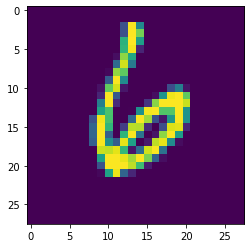

In [20]:
# Visualize the Data
g = plt.imshow(X_train[0][:,:,0]) #get all values starting from 0th index

### **Create CNN Model**
#### **Data augmentation**

In [22]:
from keras.preprocessing.image import ImageDataGenerator
# helps prevent overfitting and helps the model generalize better
datagen = ImageDataGenerator(
    rotation_range=5, #a range within which to randomly rotate pictures
    width_shift_range=0.05, #randomly translate pictures vertically
    height_shift_range=0.05, #randomly translate pictures horizontally
    zoom_range=0.05, #randomly zooming inside pictures
    fill_mode='nearest',
    rescale=1./255,
)

In [23]:
# The data generator itself is in fact an iterator, returning batches of image samples when requested.
train_gen = datagen.flow(X_train, y_train, batch_size = 64)
test_gen = datagen.flow(X_test, y_test, batch_size = 64)

####**CNN**

In [24]:
from tensorflow.keras import models
from keras.models import Sequential
# set seed
tf.random.set_seed(20742)
# define the model
model = Sequential()
# set 32 filters for the two firsts conv2D layers and 64 filters for the two last ones
# each filter transforms a part of the image (defined by the kernel size) using the kernel filter
model.add(Conv2D(32,(3,3), activation='relu', input_shape = (28,28,1))),
model.add(Conv2D(64,(3,3), activation='relu', input_shape = (28,28,1))),
# acts as a downsampling filter. It looks at the 2 neighboring pixels and picks the maximal value.
model.add(MaxPooling2D(2, 2)),
# Repeat Steps 1,2,3 for adding more hidden layers
model.add(Conv2D(64,(3,3), activation='relu')), #'relu' is the rectifier (activation function max(0,x)
model.add(Conv2D(64,(3,3), activation='relu')),
model.add(MaxPooling2D(2, 2)),
model.add(Flatten()),
model.add(Dense(256, activation='relu')), #Activation functions propagate the output of one layer's nodes forward to the next layer.
model.add(Dense(10, activation='softmax')) #0-1
##These masks help prevent the model from overfitting on the training data.
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 12, 12, 64)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 10, 10, 64)        36928     
                                                                 
 conv2d_3 (Conv2D)           (None, 8, 8, 64)          36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 4, 4, 64)         0         
 2D)                                                    

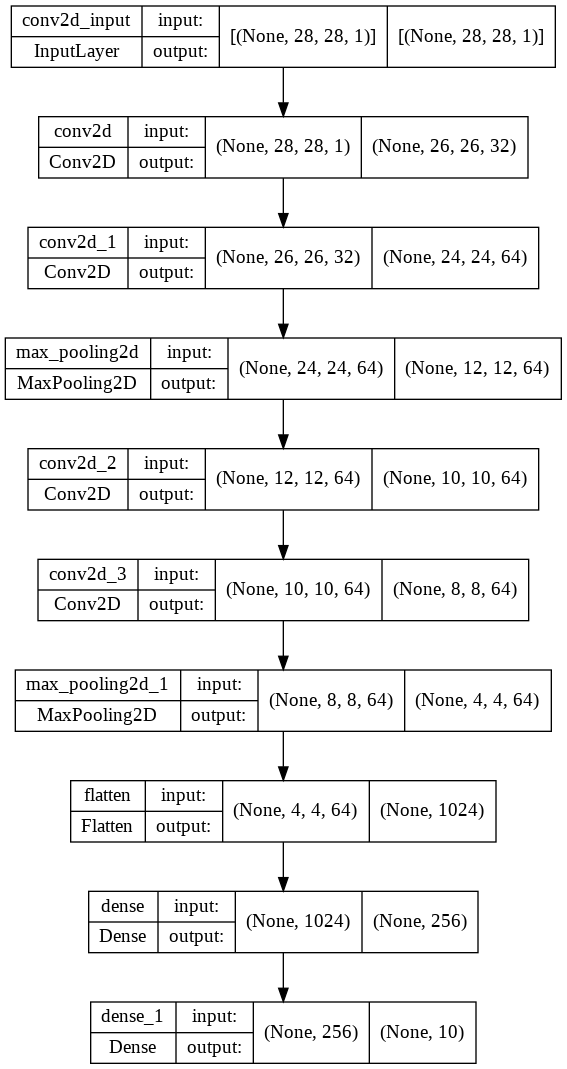

In [25]:
# After that make a fully connected network
# This fully connected network gives ability to the CNN
# to classify the samples
plot_model(model, show_shapes=True, show_layer_names=True)

### **Model Training**

In [26]:
from tensorflow.keras.optimizers import Adam

# Instantiate an optimizer and a loss function
model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])

In [27]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
# This callback will stop the training when there is no improvement in the loss for three consecutive epochs
es = EarlyStopping(
    monitor='val_accuracy', #accuracy on the validation dataset 
    min_delta=0.0001, #consider an improvement that is a specific increment 0.01% for accuracy
    patience=10, #adding a delay to the trigger in terms of the number of epochs
    verbose=1, #Training will stop when the chosen performance measure stops improving
    mode='max', #we would seek a maximum for validation accuracy
    restore_best_weights=True
)

lr = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.2, #by which the learning rate will be reduced
    patience=5, #number of epochs with no improvement after which learning rate will be reduced
    verbose=1, #int. 0: quiet, 1: update messages.
    mode='max', #will be reduced when the quantity monitored has stopped increasing
    min_delta=0.0001, #threshold for measuring the new optimum, to only focus on significant changes.
    min_lr=0.00001 #lower bound on the learning rate
) #When it comes to the larger datasets, learning faster would have a great impact on the performance of the model.

In [28]:
batch_size = 64
# calling train_step on batches of images
train_steps = len(X_train) / batch_size
test_steps = len(X_test) / batch_size
# Fit the model
# record model performance on a validation dataset during training
history = model.fit(
    train_gen,
    validation_data = test_gen,
    epochs = 20, 
    steps_per_epoch = train_steps,
    validation_steps = test_steps,
    callbacks=[es, lr],
    verbose=1
)

print("\n[INFO] Train Accuracy:", "{:.5f}%".format(history.history['accuracy'][-1]*100))
print("[INFO] Train Loss    :", "{:.7f}".format(history.history['loss'][-1]))
print("[INFO] Test Accuracy  :", "{:.5f}%".format(history.history['val_accuracy'][-1]*100))
print("[INFO] Test Loss      :", "{:.7f}".format(history.history['val_loss'][-1]))

Epoch 1/20
525/525 [==============================] - 134s 253ms/step - loss: 0.2240 - accuracy: 0.9287 - val_loss: 0.0790 - val_accuracy: 0.9755 - lr: 0.0010
Epoch 2/20
525/525 [==============================] - 128s 243ms/step - loss: 0.0674 - accuracy: 0.9796 - val_loss: 0.0514 - val_accuracy: 0.9827 - lr: 0.0010
Epoch 3/20
525/525 [==============================] - 132s 252ms/step - loss: 0.0480 - accuracy: 0.9856 - val_loss: 0.0415 - val_accuracy: 0.9868 - lr: 0.0010
Epoch 4/20
525/525 [==============================] - 110s 209ms/step - loss: 0.0391 - accuracy: 0.9877 - val_loss: 0.0407 - val_accuracy: 0.9876 - lr: 0.0010
Epoch 5/20
525/525 [==============================] - 109s 208ms/step - loss: 0.0347 - accuracy: 0.9890 - val_loss: 0.0263 - val_accuracy: 0.9908 - lr: 0.0010
Epoch 6/20
525/525 [==============================] - 113s 214ms/step - loss: 0.0295 - accuracy: 0.9908 - val_loss: 0.0420 - val_accuracy: 0.9879 - lr: 0.0010
Epoch 7/20
525/525 [==========================

### Model Evaluation

In [29]:
#test data evaluation
evaluate_test = model.evaluate(X_test, y_test, verbose=1)

print("\nAccuracy =", "{:.7f}%".format(evaluate_test[1]*100))
print("Loss     =" ,"{:.9f}".format(evaluate_test[0]))

263/263 [==============================] - 7s 25ms/step - loss: 4.1273 - accuracy: 0.9952

Accuracy = 99.5238066%
Loss     = 4.127330780


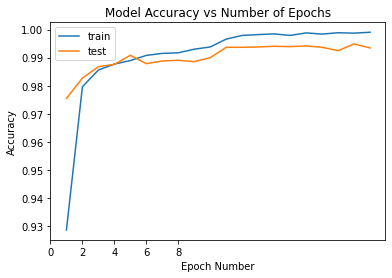

In [30]:
import matplotlib.pyplot as plt

## plotting the metrics
plt.plot(range(1,1+len(history.history['accuracy'])), history.history['accuracy'])
plt.plot(range(1,1+len(history.history['val_accuracy'])), history.history['val_accuracy'])
plt.title('Model Accuracy vs Number of Epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch Number')
plt.legend(['train', 'test'], loc='best')
plt.xticks(np.arange(0,10,2))
plt.show()

In [31]:
#reshape
#predict using test data
X_test_2 = X_test.reshape(len(X_test),28,28,1) / 255.0
y_test_2 = np.argmax(y_test, axis=-1)
y_test_pred = np.argmax(model.predict(X_test), axis=-1)

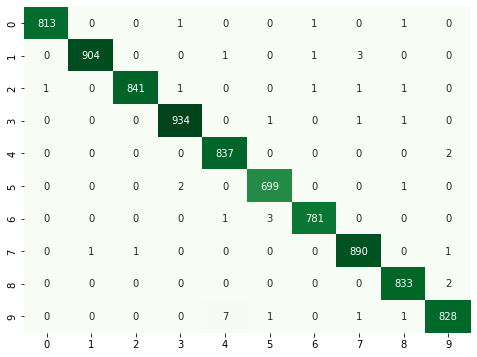

In [32]:
import seaborn as sn
from sklearn.metrics import confusion_matrix
#plot the confusion matrix of the validation results
conf_matrix = confusion_matrix(y_test_2, y_test_pred)
df_cm = pd.DataFrame(conf_matrix,
                     index = range(0,10),
                     columns = range(0,10))
plt.figure(figsize = (8,6)) #ratio 4:3
sn.heatmap(df_cm, cmap="Greens", fmt="d", cbar=False, annot=True)


### Prediction Check

In [34]:
#predict on the first ten images
preds=model.predict(X_test[:10])
# print our model prediction
print(np.argmax(preds ,axis=1))
print(y_test[:10])

[8 1 9 9 8 6 2 2 7 1]
[[0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]


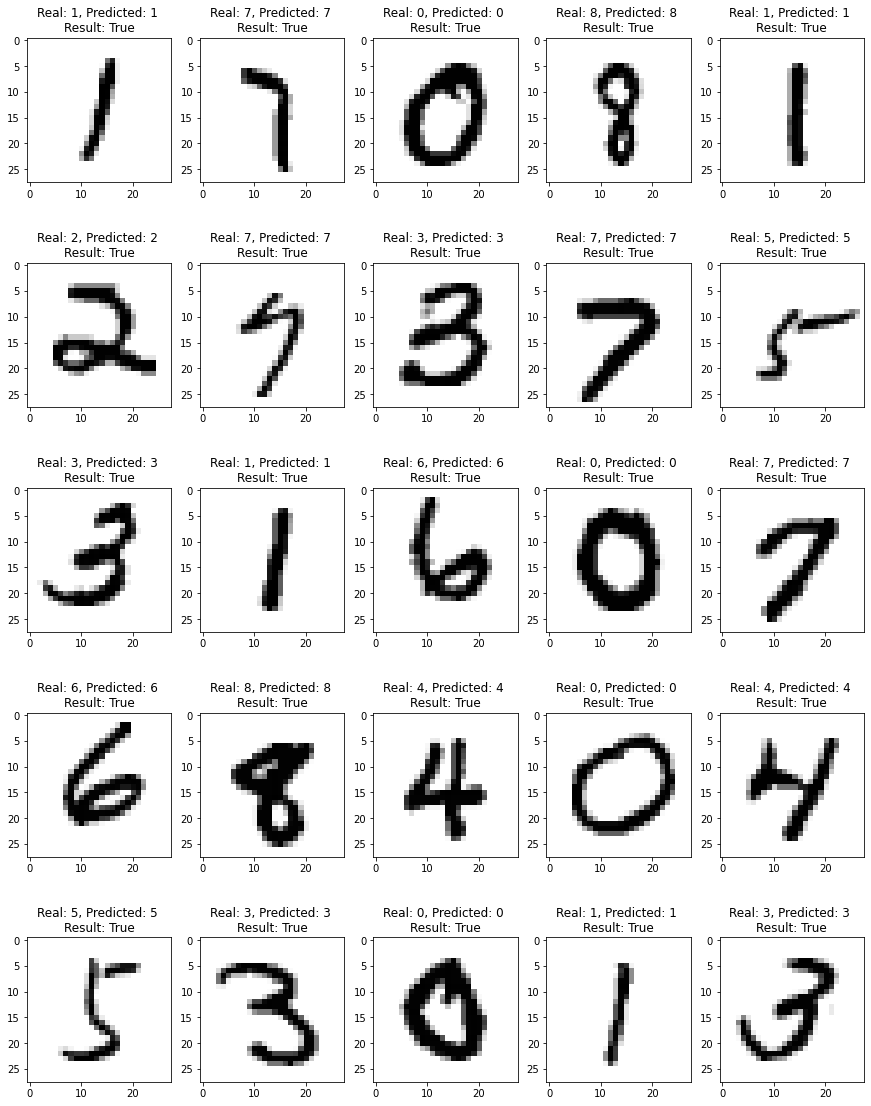

In [35]:
#visualization
fig = plt.figure(figsize=(15,20)) #ratio 3:4
for pick_random in range(1,26):
    roll_number = np.random.randint(0, len(X_test)-1)
    output_result = (y_test_2[roll_number] == y_test_pred[roll_number])
    
    fig.add_subplot(5, 5, pick_random)
    plt.title(f"Real: {y_test_2[roll_number]}, Predicted: {y_test_pred[roll_number]} \nResult: {output_result}")
    plt.imshow(X_test_2[roll_number].reshape(28,28), cmap="binary")

### Prepare And Save Submission File

In [36]:
#using model to predict test data
results = np.argmax(model.predict(test.values.reshape(-1,28,28,1)) ,axis=1)
results.shape

(28000,)

In [37]:
# check the first ten numbers
results[:10]

array([2, 0, 9, 0, 3, 7, 0, 3, 0, 3])

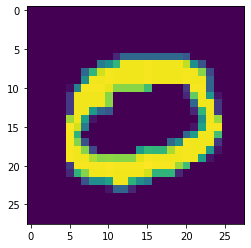

In [38]:
# Visualize the numbers with results_id
results_id = 2
g2 = plt.imshow(test.iloc[results_id-1,:].values.reshape(28,28))

In [39]:
#prepare submission dataset
submission = pd.concat([pd.Series(range(1,28001),name = "ImageId"),pd.Series(results, name="Label")],axis = 1)

submission.head()

,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,0
4,5,3


In [40]:
#save submission
submission.to_csv("BUDT737_Group_03.csv",index=False)